<a href="https://colab.research.google.com/github/kaahila/sugarcrm_documentation_data/blob/master/documentation_dataset_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Preparing Text Data for use with Retrieval-Augmented LLMs

## Required Libraries

There are a few Python libraries we must `pip install` for this notebook to run, those are:

In [ ]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.7/960.7 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.3 MB/s eta 0:00:00


## Preparing Data

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin, urlparse

In [ ]:
url = "https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/"

In [ ]:
exclude_urls = [
    'https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Integration/Web_Services/REST_API/Endpoints/'
]

def url_is_excluded(url):
  for exclude_url in exclude_urls:
      if url.startswith(exclude_url):
        return True
      return False

In [ ]:
def get_all_links(url, visited=None):
    if visited is None:
        visited = set()
    urls = []
    # Make a GET request to the URL
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all anchor tags on the page
    links = soup.find_all('a')

    # Process each link
    for link in links:
        href = link.get('href')

        # Normalize the URL by joining it with the base URL
        absolute_url = urljoin(url, href)

        # Check if the link is on the same site, not a fragment, and not already visited
        if absolute_url.startswith(url) and urlparse(absolute_url).fragment == '' and absolute_url not in visited and not url_is_excluded(absolute_url):
            visited.add(absolute_url)
            print(absolute_url)
            urls.append(absolute_url)
            # Recursive call to process the next page
            urls = urls + get_all_links(absolute_url, visited)
    return urls
# Example usage
links = get_all_links(url)
print("--------------------------")
print(links)

https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/
https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Composer
https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Development_Methodology/
https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Composer/
https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Delivery_and_Deployment_Guide_for_Enterprises/
https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Migration_Guide/
https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/User_Interface/
https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/User_Interface/Sidecar/
https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0

In [ ]:
def create_folders_and_save_html(links, folder_name):
    for link in links:
        # Get the URL path and remove leading and trailing slashes
        url_path = link.strip('/').replace("https:", "rtdocs")
        print(url_path)
        # Create the recursive folders for the URL path
        os.makedirs(url_path, exist_ok=True)

        # Make a GET request to the URL
        response = requests.get(link)

        # Get the file name from the URL path
        file_name = os.path.join(url_path, 'index.html')

        # Save the HTML content to a file
        with open(file_name, 'w') as file:
            file.write(response.text)

create_folders_and_save_html(links, "rtdocs")


rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction
rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Composer
rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Development_Methodology
rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Composer
rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Delivery_and_Deployment_Guide_for_Enterprises
rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/Migration_Guide
rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/User_Interface
rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/User_Interface/Sidecar
rtdocs//support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/User_I

This downloads all HTML into the `rtdocs` directory. Now we can use LangChain itself to process these docs. We do this using the `ReadTheDocsLoader` like so:

In [ ]:
from langchain.document_loaders import ReadTheDocsLoader

loader = ReadTheDocsLoader('rtdocs', custom_html_tag=("section", {"class": "content-body"}))
docs = loader.load()
len(docs)

/usr/local/lib/python3.10/dist-packages/langchain/document_loaders/readthedocs.py:48: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 48 of the file /usr/local/lib/python3.10/dist-packages/langchain/document_loaders/readthedocs.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  _ = BeautifulSoup(
/usr/local/lib/python3.10/dist-packages/langchain/document_loaders/readthedocs.py:75: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a 

363

This leaves us with `363` processed doc pages. Let's take a look at the format each one contains:

In [ ]:
docs[0]

We access the plaintext page content like so:

In [ ]:
print(docs[0].page_content)

Introduction
Overview
The Sugar Developer Guide is an essential resource for developers who are new to Sugar or to CRM and web-based applications. ItÂ describes how to configure and customize the Sugar platform for a broad range of tasks applicable to any organization that has a need to manage business relationships with people.
Prerequisites
Using and understanding theÂ documentation contained in the Sugar Developer Guide requires basic programming and software development knowledge. Specifically, you should be familiar with the PHP general-purpose scripting language and the SQL programming language for accessing databases.
Understanding Sugar's Framework
Designed as the most modern web-based CRM platform available today, Sugar has quickly become the business application standard for companies around the world.Â The Sugar application framework has a sophisticated extension model built into it, allowing developers to make significant customizations to the application in an upgrade-safe

In [ ]:
print(docs[5].page_content)

Cookbook
Welcome to the SugarCRM Developer Cookbook! This library is filled with real-world code examples for common Sugar customizations and best practices. Sugar's DevClub is always cooking up new ideas, so be sure to check in often and see what's new. Get started by browsing the categories below.
TopicsAdding Buttons to the Record ViewThis example explains how to create additional buttons on the record view and add events. We will extend and override the stock Accounts record view to add a custom button. The custom button will be called "Validate Postal Code" and ping the Zippopotamus REST service to validate the records billing state and postal code.Adding Field Validation to the Record ViewThis page explains how to add additional field validation to the record view. In the following examples, we will extend and override the stock Accounts record view to add custom validation. The custom validation will require the Office Phone field when the account type is set to "Customer" and a

We can also find the source of each document:

In [ ]:
docs[5].metadata['source'].replace('rtdocs/', 'https://')

'https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Cookbook/index.html'

Looks good, we need to also consider the length of each page with respect to the number of tokens that will reasonably fit within the window of the latest LLMs. We will use `gpt-3.5-turbo` as an example.

To count the number of tokens that `gpt-3.5-turbo` will use for some text we need to initialize the `tiktoken` tokenizer.

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

Note that for the tokenizer we defined the encoder as `"cl100k_base"`. This is a specific tiktoken encoder which is used by `gpt-3.5-turbo`. Other encoders exist. At the time of writing the OpenAI specific tokenizers (using `tiktoken`) are summarized as:

| Encoder | Models |
| --- | --- |
| `cl100k_base` | `gpt-4`, `gpt-3.5-turbo`, `text-embedding-ada-002` |
| `p50k_base` | `text-davinci-003`, `code-davinci-002`, `code-cushman-002` |
| `r50k_base` | `text-davinci-001`, `davinci`, `text-similarity-davinci-001` |
| `gpt2` | `gpt2` |

You can find these details in the [Tiktoken `model.py` script](https://github.com/openai/tiktoken/blob/main/tiktoken/model.py), or using `tiktoken.encoding_for_model`:

In [ ]:
tiktoken.encoding_for_model('text-curie-001')

<Encoding 'r50k_base'>

Using the `tiktoken_len` function, let's count and visualize the number of tokens across our webpages.

In [ ]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

Let's see `min`, average, and `max` values:

In [ ]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 10
Avg: 1211
Max: 30136


Now visualize:

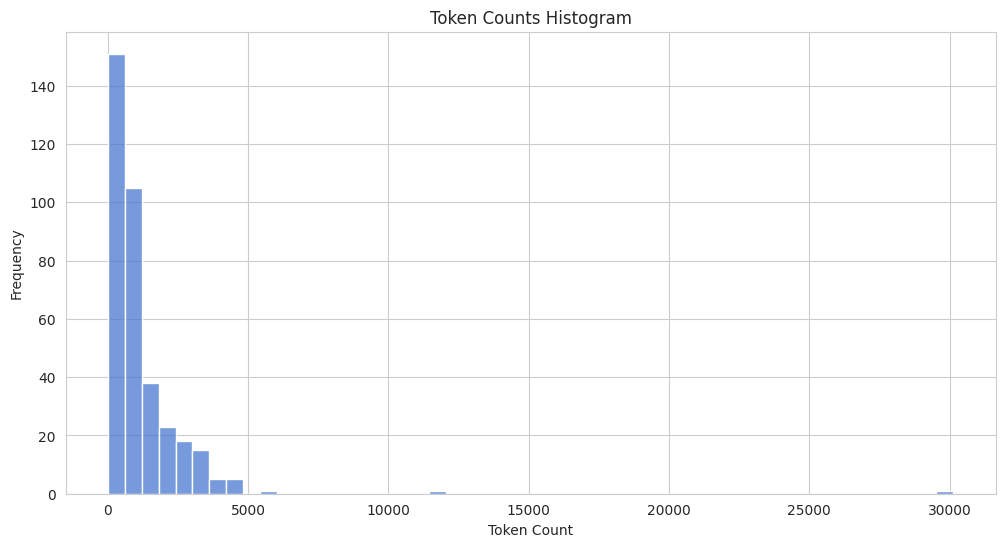

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

The vast majority of pages seem to contain a lower number of tokens. But our limits for the number of tokens to add to each chunk is actually smaller than some of the smaller pages. But, how do we decide what this number should be?

### Chunking the Text

At the time of writing, `gpt-3.5-turbo` supports a context window of 4096 tokens — that means that input tokens + generated ( / completion) output tokens, cannot total more than 4096 without hitting an error.

So we 100% need to keep below this. If we assume a very safe margin of ~2000 tokens for the input prompt into `gpt-3.5-turbo`, leaving ~2000 tokens for conversation history and completion.

With this ~2000 token limit we may want to include *five* snippets of relevant information, meaning each snippet can be no more than **400** token long.

To create these snippets we use the `RecursiveCharacterTextSplitter` from LangChain. To measure the length of snippets we also need a *length function*. This is a function that consumes text, counts the number of tokens within the text (after tokenization using the `gpt-3.5-turbo` tokenizer), and returns that number. We define it like so:

With the length function defined we can initialize our `RecursiveCharacterTextSplitter` object like so:

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

Then we split the text for a document like so:

In [ ]:
chunks = text_splitter.split_text(docs[1].page_content)
len(chunks)

11

In [ ]:
tiktoken_len(chunks[0]), tiktoken_len(chunks[1])

(373, 371)

For `docs[5]` we created `2` chunks of token length `346` and `247`.

This is for a single document, we need to do this over all of our documents. While we iterate through the docs to create these chunks we will reformat them into a format that looks like:

```json
[
    {
        "id": "abc-0",
        "text": "some important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    },
    {
        "id": "abc-1",
        "text": "the next chunk of important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    }
    ...
]
```

The `"id"` will be created based on the URL of the text + it's chunk number.

In [ ]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

url = docs[5].metadata['source'].replace('rtdocs/', 'https://')
print(url)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Cookbook/index.html
15805d7adcb3


Then use the `uid` alongside chunk number and actual `url` to create the format needed:

In [ ]:
data = [
    {
        'id': f'{uid}-{i}',
        'text': chunk,
        'source': url
    } for i, chunk in enumerate(chunks)
]
data

[{'id': '15805d7adcb3-0',
  'text': "Delivery and Deployment Guide for Enterprises\nOverview\nSugarCRM Professional Services has a set of best practices for managing instances, delivering upgraded customizations, and deploying those upgraded customizations into Sugar on-site for our Enterprise customers. The following is an example of deployment practices used by SugarCRM Professional Services team when engaged on Enterprise Sugar development projects. It does not list all possible customizations that can be made in the system, it is intended to be used as a guide for how to automate the deployment of certain types of customizations into an on-premise Sugar instance. The techniques belowÂ\xa0cannot be used withÂ\xa0Sugar's cloud service.\nDeploying Application Configuration and Metadata\nUse Case: Deployment of System Settings\nSystem settings are stored in various places. In this section, we will address each type of storage for settings, and how to migrate each.\n Storage types: \nco

Now we repeat the same logic across our full dataset:

In [ ]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('rtdocs/', 'https://')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)

  0%|          | 0/363 [00:00<?, ?it/s]

1428

We're now left with `2201` documents. We can save them to a JSON lines (`.jsonl`) file like so:

In [ ]:
import json

with open('train-cl100k_base.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')

To load the data from file we'd write:

In [ ]:
documents = []

with open('train-p50k_base.jsonl', 'r') as f:
    for line in f:
        documents.append(json.loads(line))

len(documents)

5233

In [ ]:
documents[0]

{'id': '53ccb2ae0280-0',
 'text': "Introduction\nOverview\nThe Sugar Developer Guide is an essential resource for developers who are new to Sugar or to CRM and web-based applications. ItÂ\xa0describes how to configure and customize the Sugar platform for a broad range of tasks applicable to any organization that has a need to manage business relationships with people.\nPrerequisites\nUsing and understanding theÂ\xa0documentation contained in the Sugar Developer Guide requires basic programming and software development knowledge. Specifically, you should be familiar with the PHP general-purpose scripting language and the SQL programming language for accessing databases.\nUnderstanding Sugar's Framework",
 'source': 'https://support.sugarcrm.com/Documentation/Sugar_Developer/Sugar_Developer_Guide_13.0/Introduction/index.html'}